## Import libraries

In [5]:
import os
from tqdm.notebook import tqdm
import face_recognition
import matplotlib.pyplot as plt
import pandas as pd
import uuid
import chromadb
from chromadb.config import Settings
pd.set_option('display.max_columns', None)

In [44]:
PRADO_PATH = os.getenv("PRADO_PATH")
assert PRADO_PATH is not None, f"Please set the env variable PRADO_PATH"
assert os.path.isdir(PRADO_PATH), "PRADO_PATH must be a dir"

# Load our face embedding DB

In [12]:
DETECTION_MODEL = "hog"  # hog - cnn
DB_NAME = f"chromadb_prado_faces_{DETECTION_MODEL}"
COLLECTION_NAME = "hog_faces"

In [13]:
# Optional, defaults to .chromadb/ in the current directory
client = chromadb.Client(Settings(
    chroma_db_impl="duckdb+parquet",
    persist_directory=DB_NAME
))
client.persist()

True

In [15]:
client.list_collections()

[Collection(name=hog_faces)]

In [14]:
collection = client.get_collection(name=COLLECTION_NAME)
print(f"Items in collection: {collection.count()}")

Items in collection: 8678


# Get a face and generate embedding

Image loaded! Dimensions: (500, 1000, 3)


(-0.5, 999.5, 499.5, -0.5)

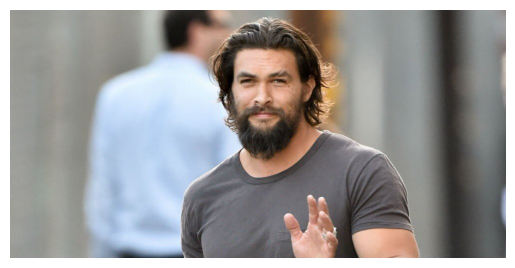

In [109]:
image_path = "test/jason.jpg"
image = face_recognition.load_image_file(image_path)
print(f"Image loaded! Dimensions: {image.shape}")
plt.imshow(image)
plt.axis("off")

## Extract the face locations and embeddings

In [110]:
# https://face-recognition.readthedocs.io/en/latest/face_recognition.html#face_recognition.api.face_locations
faces_locations = face_recognition.face_locations(
    image,
    model=DETECTION_MODEL,
    number_of_times_to_upsample=1
)

faces_embeddings = face_recognition.face_encodings(
    image,
    known_face_locations=faces_locations,
    num_jitters=1,
    model="large"
)

assert len(faces_locations) == len(faces_embeddings), f"{len(faces_locations)} faces founds but {len(faces_embeddings)} embeddings generated"
print(f"{len(faces_locations)} face{'' if len(faces_locations) == 1 else 's'} found")

1 face found


In [111]:
print(f"First face embedding shape: {faces_embeddings[0].shape}")

First face embedding shape: (128,)


Face width 155 and height 155


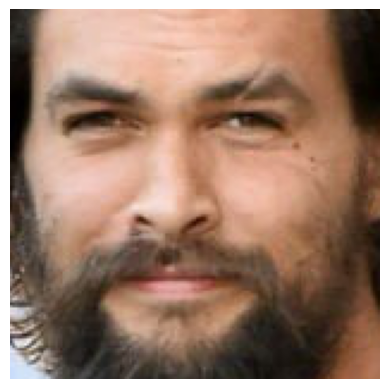

In [112]:
for indx, face_location in enumerate(faces_locations):
    # Get the location of each face in this image
    top, right, bottom, left = face_location
    width = abs(right - left)
    height = abs(bottom - top)
    print(f"Face width {width} and height {height}")
    # Get the face path
    face = image[top:bottom, left:right]
    # We take the face and transform it and cast into a torch format
    #face_encs = face_recognition.face_encodings(face, num_jitters=1)
    
    plt.imshow(face)
    plt.axis("off")

# Find Nearest face

In [113]:
ranked_info = collection.query(
    query_embeddings=faces_embeddings[0].tolist(),
    n_results=3,
    where={"width": {"$gte": 100}},  # Only images with width equal/greater than 100
)

ranked_metadata = ranked_info["metadatas"][0]

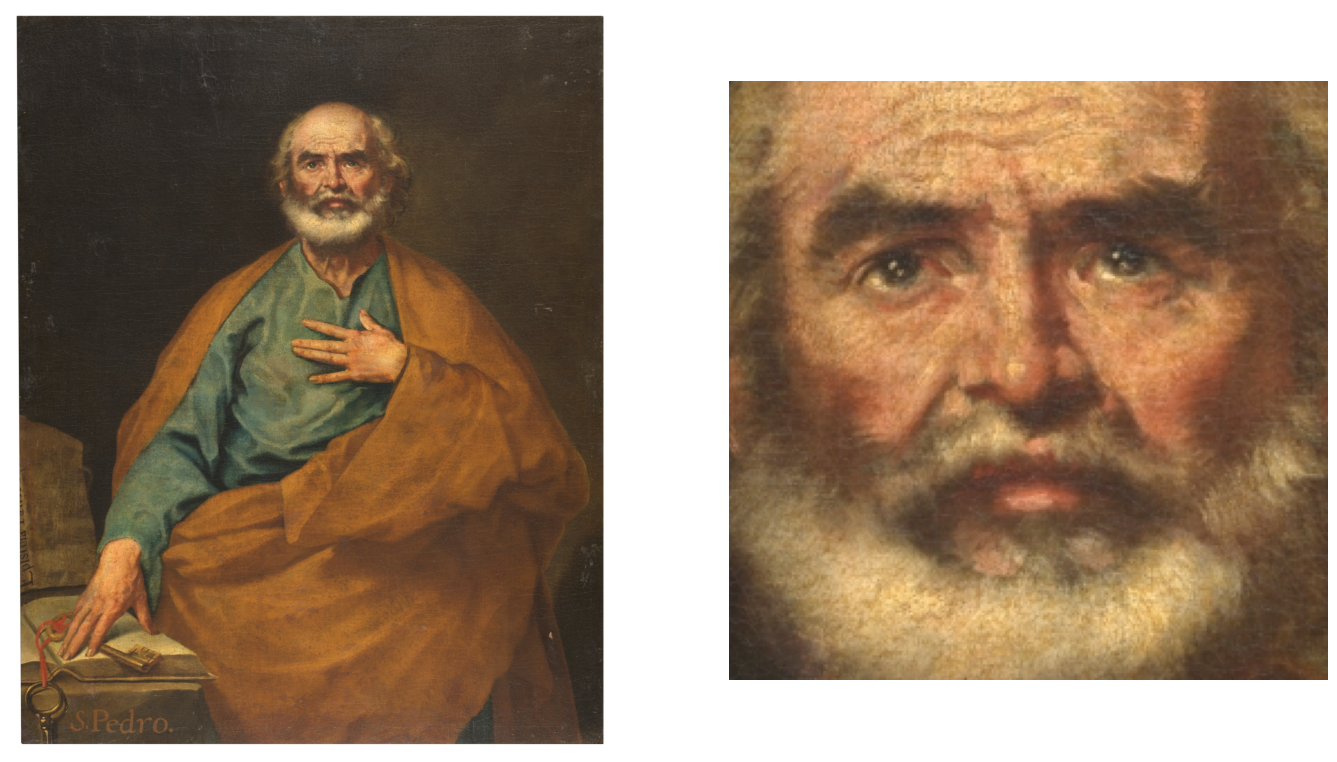

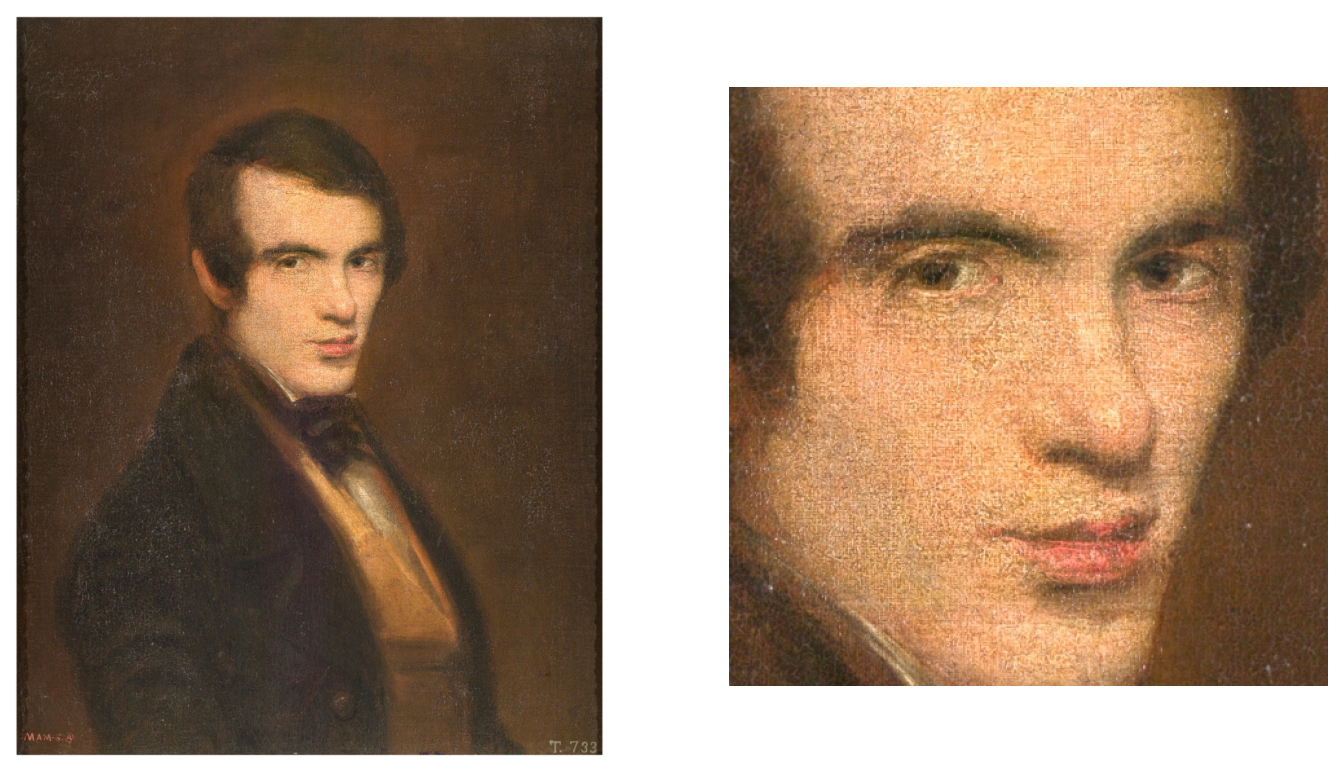

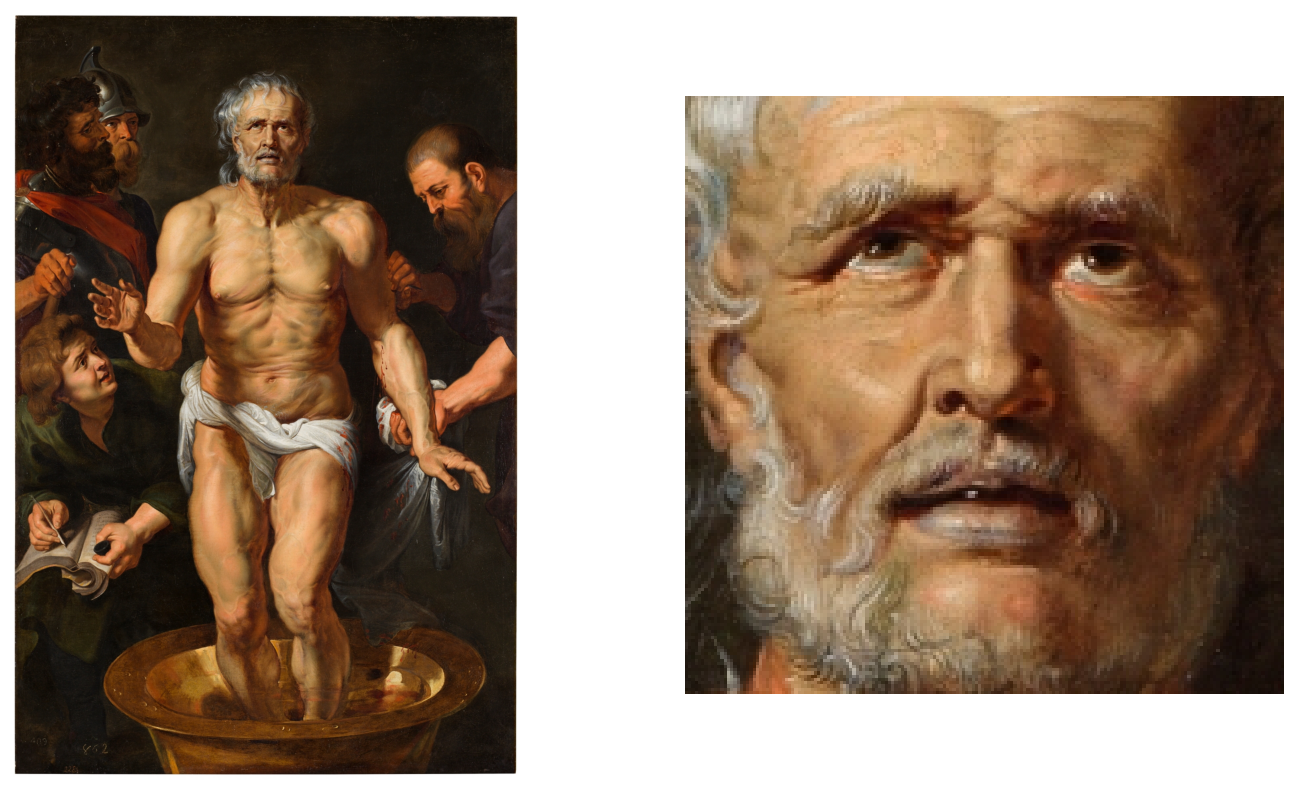

In [114]:
for ranked_meta in ranked_metadata:
    ranked_path = os.path.join(PRADO_PATH, "images", ranked_meta["image_id"])
    ranked_img = face_recognition.load_image_file(ranked_path)
    
    top = ranked_meta["fl_top"]
    right = ranked_meta["fl_right"]
    bottom = ranked_meta["fl_bottom"]
    left = ranked_meta["fl_left"]
    
    ranked_face = ranked_img[top:bottom, left:right]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 10))

    ax1.imshow(ranked_img)
    ax1.axis("off")

    ax2.imshow(ranked_face)
    ax2.axis("off")